In [1]:
# --- Bibliotecas para Manipulação e Modelagem ---
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

# --- Bibliotecas para Visualização ---
import matplotlib.pyplot as plt
from pathlib import Path

# --- Configurações de Estilo ---
plt.style.use('seaborn-v0_8-whitegrid')
print("Bibliotecas importadas com sucesso.")

# --- Carregamento dos Dados (Nova Diretriz) ---
caminho_saida_parquet = r'D:\DOUTORADO\DOUTORADO_NOTEBOOK_JPY/df_DocFinal2025.parquet'
df = pd.read_parquet(caminho_saida_parquet)


print("DataFrame carregado com sucesso a partir do arquivo Parquet.")
df.info()

Bibliotecas importadas com sucesso.
DataFrame carregado com sucesso a partir do arquivo Parquet.
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5112 entries, 2020-07-17 00:00:00 to 2020-09-25 23:40:00
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ph             5112 non-null   float64
 1   od             5112 non-null   float64
 2   ta             5112 non-null   float64
 3   te             5112 non-null   float64
 4   um             5112 non-null   float64
 5   orp            5112 non-null   float64
 6   ec             5112 non-null   float64
 7   tds            5112 non-null   float64
 8   hora           5112 non-null   int64  
 9   radiacao       5112 non-null   float64
 10  chuva          5112 non-null   float64
 11  vel_vento      5112 non-null   float64
 12  dir_vento      5112 non-null   float64
 13  umid_ins       5112 non-null   float64
 14  pressao_ins    5112 non-null   float64
 15  pto_orv


Tamanho do conjunto de treino: 4608 amostras
Tamanho do conjunto de teste: 504 amostras


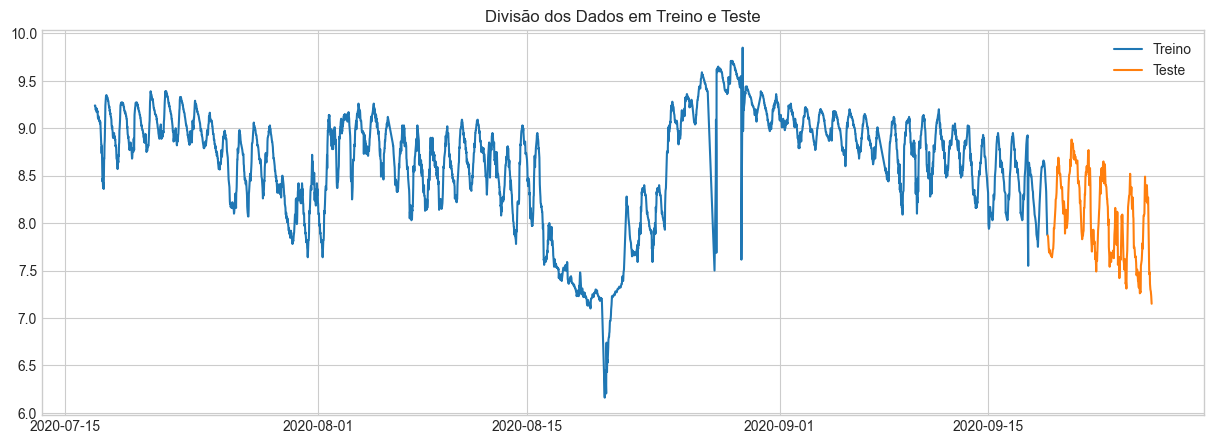

In [2]:
# --- Divisão dos Dados em Treino e Teste ---

# Vamos usar os últimos 7 dias de dados como nosso conjunto de teste
# 7 dias * 24 horas/dia * 3 medições/hora = 504 pontos de dados
test_size = 7 * 24 * 3 
train_df = df[:-test_size]
test_df = df[-test_size:]

print(f"\nTamanho do conjunto de treino: {len(train_df)} amostras")
print(f"Tamanho do conjunto de teste: {len(test_df)} amostras")

# Visualização da divisão
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(train_df.index, train_df['ph'], label='Treino')
ax.plot(test_df.index, test_df['ph'], label='Teste')
ax.set_title('Divisão dos Dados em Treino e Teste')
ax.legend()
plt.show()

--- Resultados do Modelo Naive ---
MAE (Mean Absolute Error): 0.3751
RMSE (Root Mean Squared Error): 0.4481


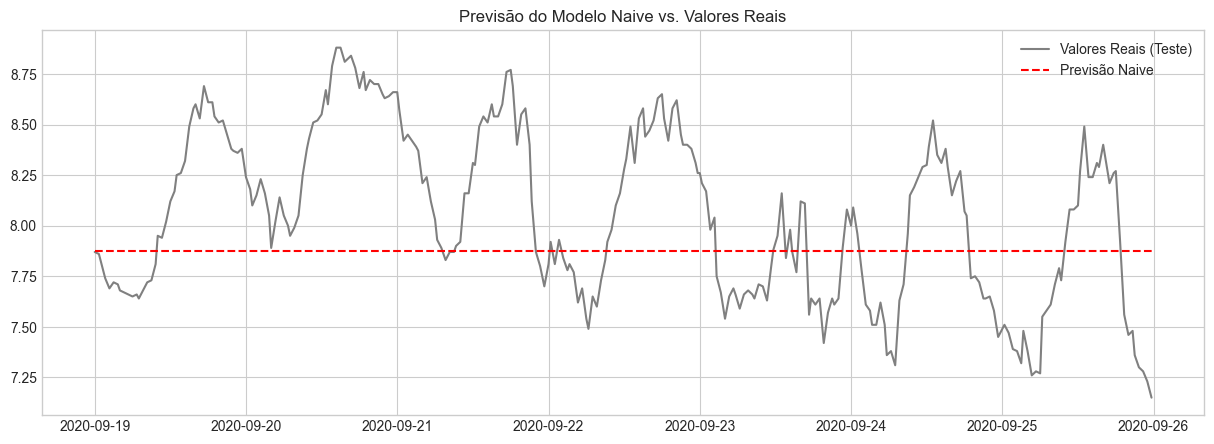

In [3]:
# --- Modelo Naive (Previsão Persistente) ---
# Naive Forecast: A previsão para qualquer ponto no futuro é o último valor observado.

# Neste caso, vamos usar o último valor do conjunto de treino
last_value_train = train_df['ph'].iloc[-1]
naive_forecast = pd.Series(last_value_train, index=test_df.index)

# Calculando as métricas de erro
mae_naive = mean_absolute_error(test_df['ph'], naive_forecast)
rmse_naive = np.sqrt(mean_squared_error(test_df['ph'], naive_forecast))

print("--- Resultados do Modelo Naive ---")
print(f"MAE (Mean Absolute Error): {mae_naive:.4f}")
print(f"RMSE (Root Mean Squared Error): {rmse_naive:.4f}")

# Visualização da previsão
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(test_df.index, test_df['ph'], label='Valores Reais (Teste)', color='gray', linewidth=1.5)
ax.plot(test_df.index, naive_forecast, label='Previsão Naive', color='red', linestyle='--')
ax.set_title('Previsão do Modelo Naive vs. Valores Reais')
ax.legend()
plt.show()

--- Resultados do Modelo Seasonal Naive ---
MAE (Mean Absolute Error): 0.3019
RMSE (Root Mean Squared Error): 0.3974


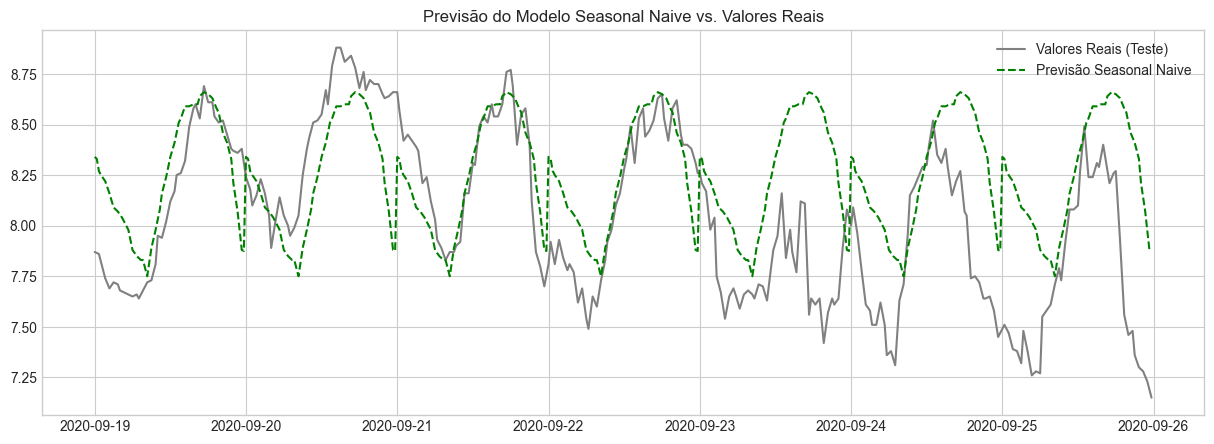

In [4]:
# --- Modelo Seasonal Naive ---

# Para nossos dados (frequência de 20 min), o período da sazonalidade diária é 3 * 24 = 72
seasonal_period = 72

# Criamos a previsão deslocando os valores de treino pelo período sazonal
# Pegamos os últimos 'seasonal_period' valores do conjunto de treino
last_season = train_df['ph'][-seasonal_period:]

# Replicamos esses valores para cobrir todo o conjunto de teste
num_replications = int(np.ceil(len(test_df) / seasonal_period))
seasonal_forecast_values = np.tile(last_season, num_replications)[:len(test_df)]
seasonal_naive_forecast = pd.Series(seasonal_forecast_values, index=test_df.index)

# Calculando as métricas de erro
mae_seasonal_naive = mean_absolute_error(test_df['ph'], seasonal_naive_forecast)
rmse_seasonal_naive = np.sqrt(mean_squared_error(test_df['ph'], seasonal_naive_forecast))

print("--- Resultados do Modelo Seasonal Naive ---")
print(f"MAE (Mean Absolute Error): {mae_seasonal_naive:.4f}")
print(f"RMSE (Root Mean Squared Error): {rmse_seasonal_naive:.4f}")

# Visualização da previsão
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(test_df.index, test_df['ph'], label='Valores Reais (Teste)', color='gray', linewidth=1.5)
ax.plot(test_df.index, seasonal_naive_forecast, label='Previsão Seasonal Naive', color='green', linestyle='--')
ax.set_title('Previsão do Modelo Seasonal Naive vs. Valores Reais')
ax.legend()
plt.show()

Iniciando o treinamento do modelo ARIMAX(8,1,0) [versão robusta]...


C:\Users\User\anaconda3\envs\doc\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 20min will be used.
  self._init_dates(dates, freq)
C:\Users\User\anaconda3\envs\doc\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 20min will be used.
  self._init_dates(dates, freq)


Treinamento concluído em 7.44 segundos.

Mensagem de convergência do otimizador:
{'fopt': np.float64(-1.2881386134554742), 'direc': array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 

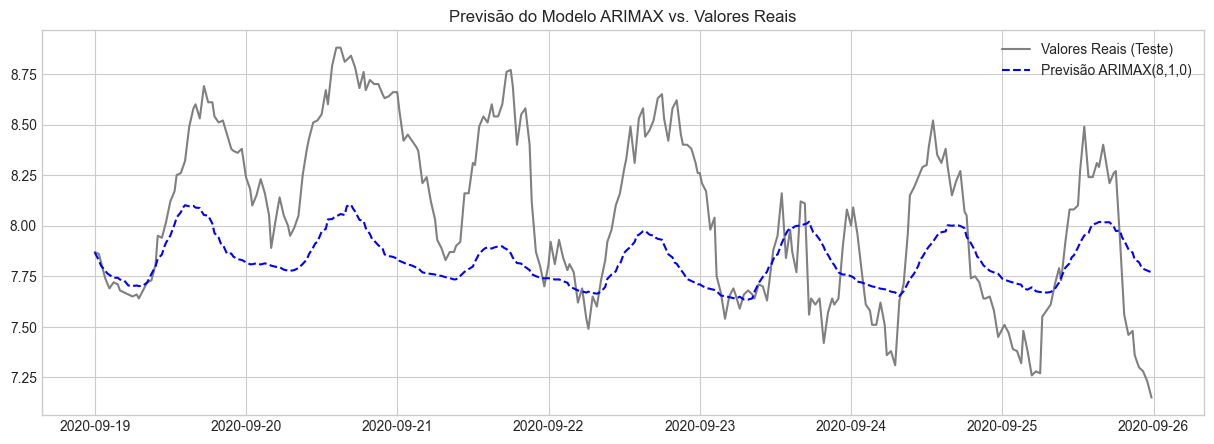

In [8]:
# --- Bibliotecas Adicionais ---
from statsmodels.tsa.statespace.sarimax import SARIMAX
import time

# --- Assumimos que train_df e test_df já existem ---

# --- Modelo ARIMAX(8,1,0) - Versão Robusta ---

# 1. Definir as variáveis exógenas
exog_vars = ['radiacao', 'orp', 'od', 'te', 'ta', 'tds']
train_exog = train_df[exog_vars]
test_exog = test_df[exog_vars]

# 2. Criar e treinar o modelo
print("Iniciando o treinamento do modelo ARIMAX(8,1,0) [versão robusta]...")
start_time = time.time()

arimax_model = SARIMAX(train_df['ph'], 
                       exog=train_exog, 
                       order=(8, 1, 0), 
                       seasonal_order=(0, 0, 0, 0))

# Modificação: Trocando o método de otimização e aumentando as iterações
arimax_results = arimax_model.fit(disp=False, method='powell', maxiter=500)

end_time = time.time()
print(f"Treinamento concluído em {end_time - start_time:.2f} segundos.")

# Verificando a mensagem de convergência
print("\nMensagem de convergência do otimizador:")
print(arimax_results.mle_retvals)

# 3. Gerar previsões e calcular métricas (com tratamento de erro)
try:
    arimax_forecast = arimax_results.get_forecast(steps=len(test_df), exog=test_exog)
    arimax_forecast_mean = arimax_forecast.predicted_mean

    mae_arimax = mean_absolute_error(test_df['ph'], arimax_forecast_mean)
    rmse_arimax = np.sqrt(mean_squared_error(test_df['ph'], arimax_forecast_mean))

    print("\n--- Resultados do Modelo ARIMAX(8,1,0) ---")
    print(f"MAE (Mean Absolute Error): {mae_arimax:.4f}")
    print(f"RMSE (Root Mean Squared Error): {rmse_arimax:.4f}")

    # 4. Visualização da previsão
    fig, ax = plt.subplots(figsize=(15, 5))
    ax.plot(test_df.index, test_df['ph'], label='Valores Reais (Teste)', color='gray', linewidth=1.5)
    ax.plot(test_df.index, arimax_forecast_mean, label='Previsão ARIMAX(8,1,0)', color='blue', linestyle='--')
    ax.set_title('Previsão do Modelo ARIMAX vs. Valores Reais')
    ax.legend()
    plt.show()

except Exception as e:
    print(f"\nOcorreu um erro ao tentar gerar a previsão: {e}")
    print("O modelo pode ainda estar instável. Tente simplificar a ordem (p,d,q) ou verificar os dados de entrada.")

In [12]:
# --- Célula Final: Tabela Comparativa dos Modelos Baseline ---

# 1. Criar um dicionário com os resultados que calculamos
results_data = {
    'Model': [
        'Naive', 
        'Seasonal Naive', 
        'ARIMAX(8,1,0) Benchmark'
    ],
    'MAE': [
        mae_naive, 
        mae_seasonal_naive, 
        mae_arimax
    ],
    'RMSE': [
        rmse_naive, 
        rmse_seasonal_naive, 
        rmse_arimax
    ]
}

# 2. Converter o dicionário para um DataFrame do Pandas
results_df = pd.DataFrame(results_data)

# 3. Ordenar o DataFrame pelo MAE para ver o melhor modelo no topo
results_df = results_df.sort_values(by='MAE', ascending=True).reset_index(drop=True)

# 4. Configurar o caminho de saída para a tabela
# Assumindo que a variável 'output_dir_tables' foi definida no início do notebook
output_dir_tables = r'D:\DOUTORADO\DOUTORADO_NOTEBOOK_JPY\tables'

output_path_table = r'D:\DOUTORADO\DOUTORADO_NOTEBOOK_JPY\tables\table02_baseline_model_comparison.csv'

# 5. Salvar a tabela em um arquivo CSV
results_df.to_csv(output_path_table, index=False)

# 6. Exibir a tabela final no notebook
print("--- Tabela Comparativa de Resultados (Baselines) ---")
display(results_df)

print(f"\nTabela de resultados salva com sucesso em: {output_path_table}")

--- Tabela Comparativa de Resultados (Baselines) ---


,Model,MAE,RMSE
0,Seasonal Naive,0.301944,0.397377
1,"ARIMAX(8,1,0) Benchmark",0.334664,0.412999
2,Naive,0.375060,0.448137



Tabela de resultados salva com sucesso em: D:\DOUTORADO\DOUTORADO_NOTEBOOK_JPY\tables\table02_baseline_model_comparison.csv
